# Paleoclimatology : temperature reconstruction between 1000 and 2100

In [1]:
%load_ext autoreload
%autoreload 2

## Import modules

In [2]:
import pandas as pd
from model import PaleoModel, PaleoModel2, PaleoModel3
import numpy as np
from gibbs import Gibbs
import matplotlib.pyplot as plt
from utils import FractionalGaussianNoise, AR1, AR2, WhiteNoise

## Load data

In [3]:
Temperatures = pd.read_csv('data/Temperatures.csv', index_col=1)['temp']
T2 = pd.read_csv('data/Temperatures2.csv', index_col=1)['temp']
Forcings = pd.read_csv('data/forcings_with_prediction.csv')
Proxies = pd.read_csv('data/Proxies.csv', index_col=1)['PCR']
V_spike = pd.read_csv('data/median_volcanic_spike.csv')['x']

[]

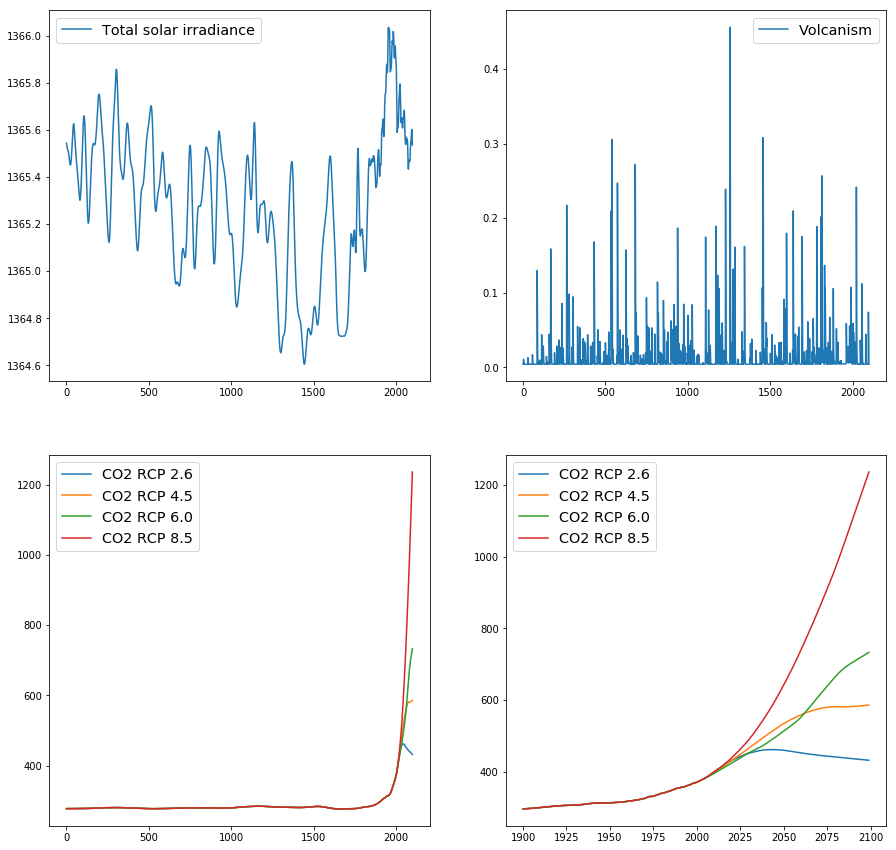

In [4]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.plot(Forcings['solar'], label='Total solar irradiance')
plt.legend(fontsize='x-large')
plt.subplot(2,2,2)
plt.plot(Forcings['volcanic'], label = 'Volcanism')
plt.legend(fontsize='x-large')
plt.subplot(2,2,3)
plt.plot(Forcings['CO2_RCP_2.6'], label = 'CO2 RCP 2.6')
plt.plot(Forcings['CO2_RCP_4.5'], label = 'CO2 RCP 4.5')
plt.plot(Forcings['CO2_RCP_6.0'], label = 'CO2 RCP 6.0')
plt.plot(Forcings['CO2_RCP_8.5'], label = 'CO2 RCP 8.5')
plt.legend(fontsize='x-large')
plt.subplot(2,2,4)
plt.plot(Forcings['CO2_RCP_2.6'][1900:], label = 'CO2 RCP 2.6')
plt.plot(Forcings['CO2_RCP_4.5'][1900:], label = 'CO2 RCP 4.5')
plt.plot(Forcings['CO2_RCP_6.0'][1900:], label = 'CO2 RCP 6.0')
plt.plot(Forcings['CO2_RCP_8.5'][1900:], label = 'CO2 RCP 8.5')
plt.legend(fontsize='x-large')
plt.plot()

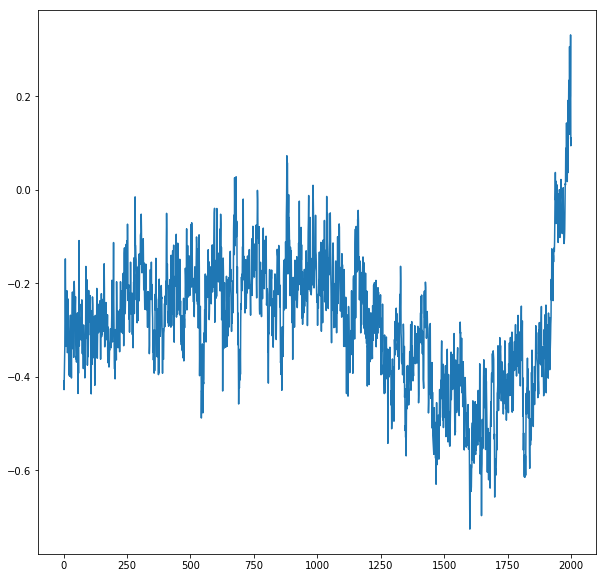

In [5]:
plt.figure(figsize=(10,10))
plt.plot(Proxies)
plt.show()

In [6]:
t1, t2, t3, t4 = 1000, 1900, 2000, 2100

## Preprocess data

In [7]:
T2 = np.array(Temperatures.loc[Temperatures.index.isin(range(t2,t3))])
RP = np.array(Proxies[Proxies.index.isin(range(t1,t3))])
S  = np.array(Forcings['solar'].loc[Forcings.index.isin(range(t1,t4))])
V  = np.array(Forcings['volcanic'].loc[Forcings.index.isin(range(t1,t4))])
C1 = np.array(Forcings['CO2_RCP_2.6'].loc[Forcings.index.isin(range(t1,t4))])
C2 = np.array(Forcings['CO2_RCP_4.5'].loc[Forcings.index.isin(range(t1,t4))])
C3 = np.array(Forcings['CO2_RCP_6.0'].loc[Forcings.index.isin(range(t1,t4))])
C4 = np.array(Forcings['CO2_RCP_8.5'].loc[Forcings.index.isin(range(t1,t4))])

In [8]:
c12 = (C2[-1]-C1[-1])/2
c23 = (C3[-1]-C2[-1])/2
c34 = (C4[-1]-C3[-1])/2
C1_var = c12
C2_var = min(c12, c23)
C3_var = min(c23, c34)
C4_var = c34

## Gibbs sampler

In [15]:
m = PaleoModel3(t1, t2, t3, t4, S, V, V_spike, C4, 0, T2, RP, H_init=0.6, K_init=0.5, step_H=0.03, step_K=0.03, n_iterations_MH=1)
# m = PaleoModel(t1, t2, t3, t4, S, V, C3, T2, RP, H_init=0.5, K_init=0.5, step_H=0.03, step_K=0.03, n_iterations_MH=1)

In [16]:
g = Gibbs(m, noise_H=AR1(), noise_K=AR1(), dashboard=False)

In [17]:
g.dashboard # Dashboard for live plotting

In [18]:
g.run(n=10000) # run gibbs sampler

100%|██████████| 10000/10000 [5:13:39<00:00,  1.88s/it]


## Display results

In [114]:
g.get_results(['alpha', 'beta', 'sigma_p', 'sigma_T', 'H', 'K'], last_n=500)

alpha_0 = -0.032 +/- 0.018
alpha_1 = 0.247 +/- 0.045
beta_0 = -0.195 +/- 0.038
beta_1 = 0.048 +/- 0.012
beta_2 = 0.014 +/- 0.008
beta_3 = 0.018 +/- 0.017
sigma_p = 0.057 +/- 0.004
sigma_T = 0.151 +/- 0.02
H = 0.6 +/- 0.0
K = 0.5 +/- 0.0


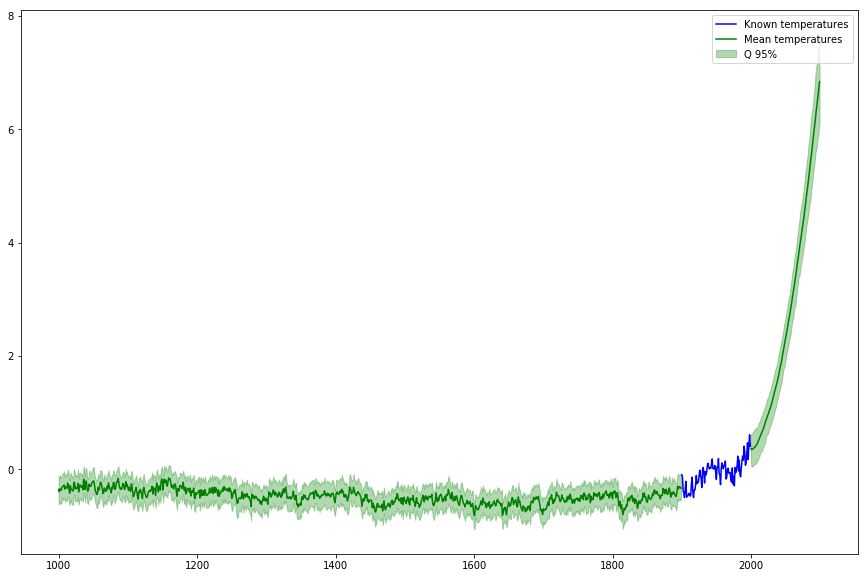

In [24]:
g.plot_T_reconstruction(last_n=500)

In [95]:
d = pd.read_csv("../Temperature data/cmip60_anomaly.csv")
d3 = pd.read_csv("../Temperature data/cmip85_anomaly.csv")

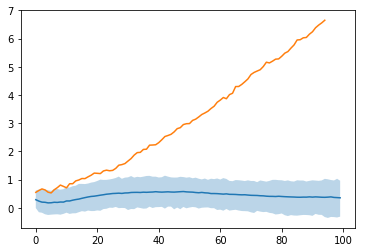

In [96]:
plt.plot(np.array(g.get_history("T13"))[-500:].mean(axis=0)[900:])
plt.fill_between(x=range(0,100),
                 y1=np.percentile(np.array(g.get_history("T13"))[-5000:], 97.5, axis=0)[900:],
                 y2=np.percentile(np.array(g.get_history("T13"))[-5000:], 2.5, axis=0)[900:], alpha=0.3)
plt.plot(d3.drop(columns=["year", "Unnamed: 0"]).mean(axis=1))

In [106]:
C = np.log(C4)
C = (C-C[:1000].mean())/C[:1000].std()

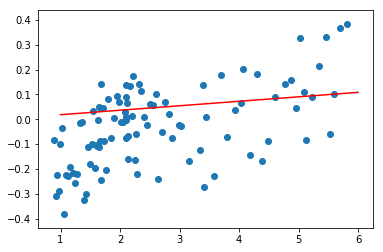

In [117]:
plt.scatter(C[901:1000], T2[1:]-0.5*T2[:-1])
x = np.linspace(1,6,100)
plt.plot(x, 0.018*x, color='r')

(5000, 2)


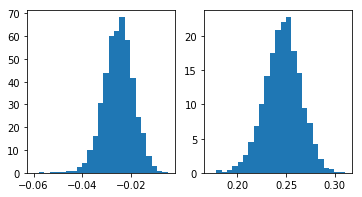

In [24]:
g.histogram('alpha', last_n=5000)

(5000, 4)


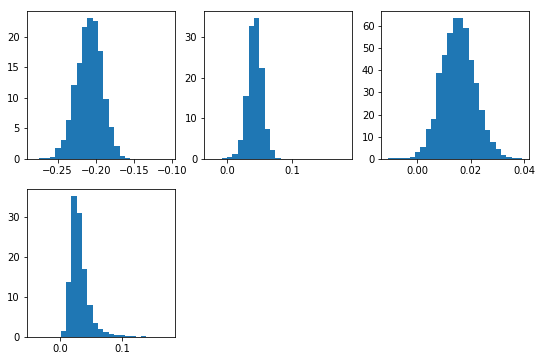

In [25]:
g.histogram('beta', last_n=5000)

(5000,)


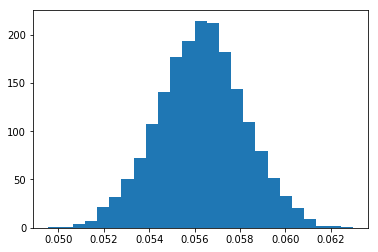

In [26]:
g.histogram('sigma_p', last_n=5000)

(1200,)


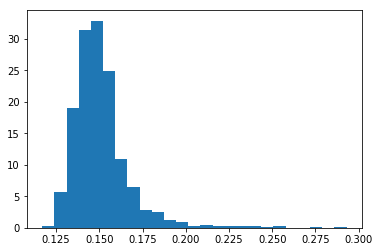

In [27]:
g.histogram('sigma_T', last_n=1200)

In [29]:
g.ECP(0.8)

0.78

In [30]:
g.ECP(0.95)

0.98

In [31]:
g.RMSE()

0.1794119874292841

In [32]:
g.CRPS(last_n=1200)

0.07371420995969447

In [33]:
g.IS(a=0.95, last_n=1200)

0.05707744766384759

In [34]:
g.IS(a=0.8, last_n=1200)

0.17001609843004062

## Save dataset

In [23]:
data = g.save_to_xarray(filename='../history/model3_RCP8.5_ex.netcdf')

In [22]:
g.model.data

{'T2': T2 = [-0.09131 -0.13062 -0.37462 -0.41322 -0.49467 -0.34764 -0.20943 -0.48854
  -0.46853 -0.46219 -0.42173 -0.42805 -0.47025 -0.45409 -0.24405 -0.13473
  -0.39316 -0.49633 -0.36044 -0.36184 -0.28043 -0.10632 -0.25145 -0.23106
  -0.22345 -0.11669 -0.01133 -0.11587 -0.14681 -0.31894 -0.01648  0.03493
  -0.07014 -0.2382  -0.0365  -0.09486 -0.04117  0.07402  0.10811  0.04145
   0.00927  0.03199  0.02162  0.10032  0.18581  0.01615  0.01855  0.00723
   0.06942 -0.03308 -0.1757   0.04426  0.03499  0.19192 -0.06654 -0.09327
  -0.26796  0.00776  0.11614  0.06807  0.01121  0.0668   0.08893  0.14732
  -0.16854 -0.13485  0.00261  0.02248 -0.06445 -0.0571  -0.05518 -0.19465
  -0.22335  0.0272  -0.25797 -0.12012 -0.28945  0.03376 -0.05516  0.00826
   0.06983  0.2362  -0.02705  0.16667 -0.0843  -0.12952  0.02553  0.15336
   0.23607  0.16474  0.4105   0.3163   0.0738   0.12691  0.27792  0.4685
   0.17332  0.45295  0.61104  0.40695] ,
 'RP': RP = [-2.29477313e-01 -2.89874881e-01 -2.23829071e-01 